In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [83]:
column_names = [
    "lat", 
    "lon", 
    "id", 
    "source_id", 
    "account_id", 
    "title", 
    "created_on", 
    "updated_on", 
    "start_ts", 
    "until_ts",
    "report_type",
    "notes", 
    "layer_id",
    "severity"
]

In [84]:
df = pd.read_table("reports_12DEC16-26DEC16.txt", header=None, names=column_names)

In [85]:
print df.describe()

                 lat            lon      start_ts      until_ts
count  127328.000000  127328.000000  1.273270e+05  1.273270e+05
mean       28.532422       7.615720  1.482151e+09  1.514842e+09
std        21.930051      78.080219  3.615758e+05  2.880806e+08
min       -90.000000    -179.966700  1.479071e+09  1.481548e+09
25%        18.248290     -75.590556  1.481840e+09  1.482070e+09
50%        35.000000      16.588660  1.482145e+09  1.482365e+09
75%        41.836944      70.000000  1.482444e+09  1.482671e+09
max        85.000000     179.416670  1.487462e+09  4.074174e+09


In [86]:
print df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127328 entries, 0 to 127327
Data columns (total 14 columns):
lat            127328 non-null float64
lon            127328 non-null float64
id             127328 non-null object
source_id      98997 non-null object
account_id     127328 non-null object
title          127328 non-null object
created_on     127328 non-null object
updated_on     127328 non-null object
start_ts       127327 non-null float64
until_ts       127327 non-null float64
report_type    127327 non-null object
notes          127306 non-null object
layer_id       127322 non-null object
severity       127327 non-null object
dtypes: float64(4), object(10)
memory usage: 13.6+ MB
None


In [87]:
print df.tail()

              lat         lon                      id  \
127323  17.823540   80.201640  4iPRjyXM5hGbCtUN+RcZ4Q   
127324  61.441140 -135.159450  pkNIeHDK5hGbdBXRy13KCQ   
127325  67.269167   14.365278  4hkG2R_C5hGDQQ_Ry13KCQ   
127326 -37.818230  144.966900  voujXITB5hGeMgnRy13KCQ   
127327  47.305997 -122.514200  pJsC7OvK5hGScicX_zs7xg   

                       source_id              account_id  \
127323  586176614d49f90305094db3                  GLOBAL   
127324  585eb0e04d49f92eef486184                  GLOBAL   
127325                    139889  2WtVbwcebkyXxPOJYCHndQ   
127326                    139855  2WtVbwcebkyXxPOJYCHndQ   
127327                    140407  2WtVbwcebkyXxPOJYCHndQ   

                                                    title  created_on  \
127323                   Villagers say no to ₹1 a kg rice  1482837250   
127324  Windsor Islamic Council condemns ISIS call to ...  1482649520   
127325  Bodø Airport fire and rescue staff threaten st...  1481735272   
1273

In [88]:
location_df = df[["lat", "lon"]]

In [89]:
location_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127328 entries, 0 to 127327
Data columns (total 2 columns):
lat    127328 non-null float64
lon    127328 non-null float64
dtypes: float64(2)
memory usage: 1.9 MB


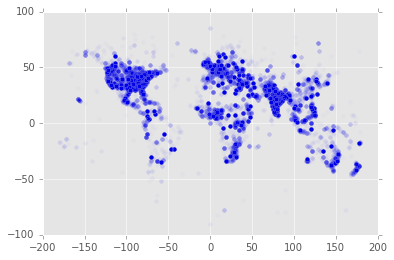

In [90]:
plt.scatter(location_df["lon"], location_df["lat"], alpha=0.02)


In [ ]:
start_timeseries = pd.Series(np.ones(len(df))).reindex(
        pd.to_datetime(
            df["start_ts"], unit="s", errors="ignore"),
        fill_value=1
)

In [146]:
daily = start_timeseries.resample("d").sum()
hourly = start_timeseries.resample("H").sum()
ten_mins = start_timeseries.resample("10T").sum()


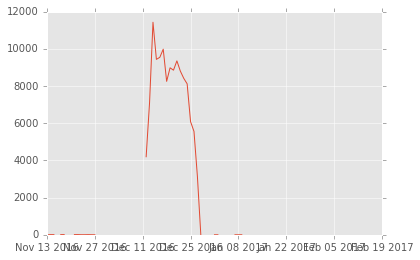

In [147]:
plt.plot(daily)

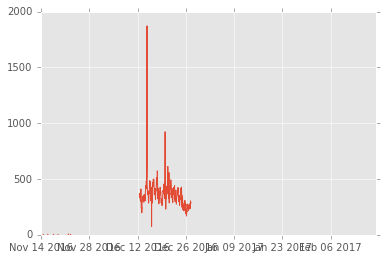

In [149]:
plt.plot(hourly)

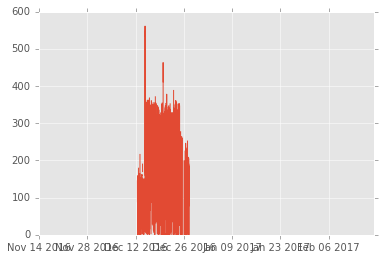

In [150]:
plt.plot(ten_mins)
